# PM2 — Conditioning and Sensitivity
Team: Camille Wardlaw, Manuel Valencia, Demircan Tas\\
Scope: Tasks C (Conditioning) and D (Sensitivity)

### Regression
- Runs model, Jacobian (analytical vs finite‑difference), and short stability checks.
- All tests passed: baseline verified; safe to proceed with PM2 analyses.

In [1]:
# Setup
import os, math, warnings
import numpy as np
import matplotlib.pyplot as plt
import time



from scipy import sparse as sp
from scipy.sparse.linalg import svds, spsolve
from numpy.linalg import cond as dense_cond

np.set_printoptions(suppress=True, linewidth=120)
np.random.seed(0)
plt.rcParams.update({'figure.figsize': (7.5,4.5), 'axes.grid': True})
os.makedirs('temp/pm2', exist_ok=True)
warnings.filterwarnings('ignore')


### Conditioning (A vs α)
- A = [[0 I]; [L −αI]]. Under steady (w=0) α cancels, so cond(A) vs α is flat.
- Larger grids increase cond(A); use as sanity only — L is the steady matrix of interest.

In [2]:
# Project imports
from getParam_Sonar import getParam_Sonar
from eval_f_Sonar import eval_f_Sonar
from eval_Jf_Sonar import eval_Jf_Sonar
from eval_Jf_FiniteDifference import eval_Jf_FiniteDifference
from eval_g_Sonar import eval_g_Sonar
from eval_u_Sonar import eval_u_Sonar
from simpleLeapFrog import LeapfrogSolver


### Conditioning (L)
- cond(L) increases with Nx; printed values are α‑independent by design.
- Digits of trust ≈ 16 − log10(cond(L)) (or −log10(cond(L)·δ) including parameter uncertainty δ).
- Pitfalls: very fine grids and weak damping are numerically stiff — consider preconditioning for larger cases.

In [3]:
# Helpers
def build_C(p):
    # Selector matrix C (H x 2N) that picks pressure at hydrophones.
    H = p['hydrophones']['n_phones']
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    C = np.zeros((H, 2*N))
    z_pos = p['hydrophones']['z_pos']
    for h, x_idx in enumerate(p['hydrophones']['x_indices']):
        if x_idx < Nx:
            k = x_idx * Nz + z_pos
            C[h, k] = 1.0
    return C

def to_dense(A):
    return A.toarray() if sp.issparse(A) else np.array(A)

def extract_L(p):
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    A = p['A']
    Lblk = A[N:, :N]
    return Lblk.toarray() if sp.issparse(Lblk) else np.array(Lblk)

def solve_steady(p, u0=1.0):
    # Solve 0 = A x + B u0 for steady-state x (neglecting dynamics).
    A, B = p['A'], p['B']
    if sp.issparse(B):
        rhs = -(B * float(u0)).toarray().ravel()
    else:
        rhs = -(B * float(u0)).ravel()
    if sp.issparse(A):
        x = spsolve(A, rhs)
    else:
        x = np.linalg.solve(A, rhs)
    return x.reshape((-1,1))

def rebuild_params_like(p, **overrides):
    # Rebuild A (for alpha,c) and B (for source position) using existing structure.
    q = dict(p)
    is_sparse = sp.issparse(p['A'])
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    A = p['A']
    # Update alpha/c by reconstructing A blocks
    alpha_new = overrides.get('alpha', p['alpha'])
    c_new = overrides.get('c', p['c'])
    c_old = p['c']
    scale = (c_new / c_old)**2 if 'c' in overrides else 1.0
    if is_sparse:
        L_blk = A[N:, :N]
        I_N = sp.eye(N, format='csr')
        L_new = L_blk * scale
        A_new = sp.bmat([[sp.csr_matrix((N, N)), I_N],
                         [L_new, -alpha_new * I_N]], format='csr')
    else:
        L_blk = A[N:, :N]
        I_N = np.eye(N)
        L_new = L_blk * scale
        A_new = np.block([[np.zeros((N, N)), I_N],
                         [L_new, -alpha_new * I_N]])
    q['A'] = A_new
    q['alpha'] = alpha_new
    q['c'] = c_new
    # Update B if sonar position overrides are provided
    si = overrides.get('sonar_ix', p['sonar_ix'])
    sj = overrides.get('sonar_iz', p['sonar_iz'])
    if ('sonar_ix' in overrides) or ('sonar_iz' in overrides):
        def idx(i,j):
            return i * Nz + j
        if is_sparse:
            B = sp.lil_matrix((2*N,1), dtype=float)
            B[N + idx(si,sj), 0] = 1.0 / (p['dx']*p['dz'])
            q['B'] = B.tocsr()
        else:
            B = np.zeros((2*N,1))
            B[N + idx(si,sj), 0] = 1.0 / (p['dx']*p['dz'])
            q['B'] = B
        q['sonar_ix'] = si
        q['sonar_iz'] = sj
    return q


### Sensitivity dp selection (steady QoI)
- Absolute vs relative curves: pick dp in the plateau (between truncation at large dp and roundoff at tiny dp).
- Steady QoI: α ≈ 0 as expected; c is influential.
- Report dp near the middle of the plateau for each parameter.

## Quick Regression (sanity)

### Transient α (peak hydrophone amplitude)
- α affects dynamics: peak |y(t)| shows non‑zero sensitivity; steady‑state hides this.
- Use dp plateau for reporting |d y_peak / dα|.

COMPLETE SONAR MODEL TEST SUITE

PART A: MODEL FUNCTIONALITY TESTS

TEST 1: Matrix Dimensions
----------------------------------------
✓ PASSED: Matrix dimensions correct

TEST 2: Zero Input Response
----------------------------------------
✓ PASSED: Zero state remains stable

TEST 3: Source Excitation
----------------------------------------
✓ PASSED: Source generates signal: 9.51e-01 Pa

TEST 4: CFL Condition
----------------------------------------
✓ PASSED: Timestep 0.001241 respects CFL

TEST 5: Hydrophone Configuration
----------------------------------------
✓ PASSED: 5 hydrophones configured

TEST 6: Short-term Stability
----------------------------------------
started running a simple solver, please wait...
✓ PASSED: No immediate divergence

PART B: JACOBIAN TEST BENCH

TEST 7: Linear System Check
----------------------------------------
✓ PASSED: Jacobian equals A matrix (linear system)

TEST 8: Finite Difference Verification
----------------------------------------
  dx = 1.

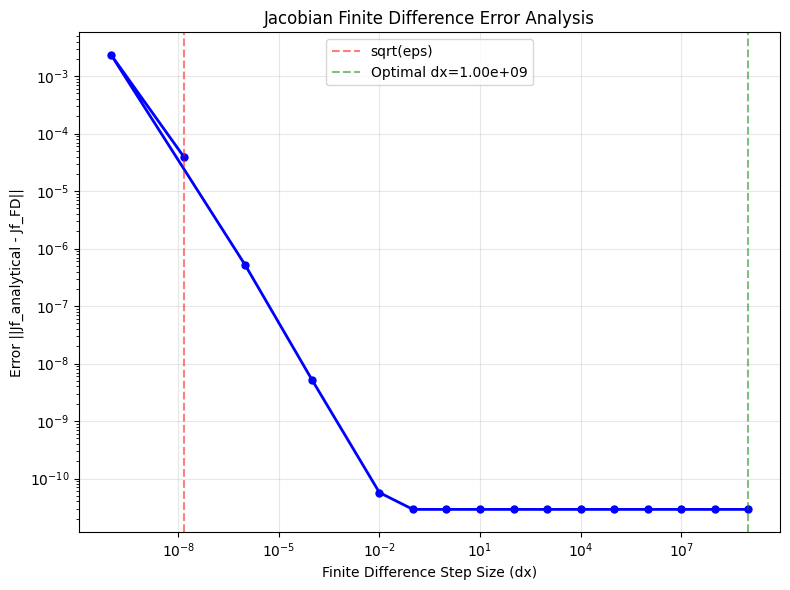


COMPLETE TEST SUMMARY
Total Tests Passed: 10
Total Tests Failed: 0
Overall Success Rate: 100.0%

✓ ALL TESTS PASSED!
PM2 regression summary — passed: 10, failed: 0


In [4]:
from test_Sonar import test_sonar_complete
passed, failed = test_sonar_complete()
print(f'PM2 regression summary — passed: {passed}, failed: {failed}')

### Source index sensitivity (per hydrophone)
- Largest magnitudes near the source direction (x or z).
- Sign shows direction: moving the source toward (+) or away (−) a hydrophone increases/decreases pressure.

## Task C — Conditioning

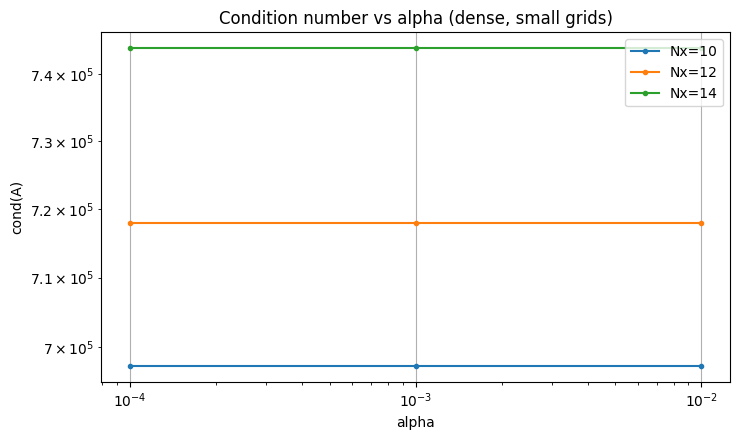

In [5]:
# Explore cond(A) vs alpha and grid size (dense for small grids)
def measure_cond(Nx_list=(10,12,14), Nz=10, Lx=100, Lz=50, alphas=(1e-4, 1e-3, 1e-2)):
    records = []
    for Nx in Nx_list:
        for alpha in alphas:
            p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False)
            p = rebuild_params_like(p, alpha=alpha)
            A = to_dense(p['A'])
            try:
                kappa = dense_cond(A)
            except Exception:
                kappa = np.nan
            records.append((Nx, alpha, kappa))
    return np.array(records, dtype=object)

rec = measure_cond()
for Nx in sorted(set(rec[:,0])):
    mask = rec[:,0]==Nx
    plt.loglog(rec[mask,1].astype(float), rec[mask,2].astype(float), '.-', label=f'Nx={int(Nx)}')
plt.xlabel('alpha')
plt.ylabel('cond(A)')
plt.title('Condition number vs alpha (dense, small grids)')
plt.legend(); plt.tight_layout(); plt.show()


## Task D — Sensitivity (Finite Differences)

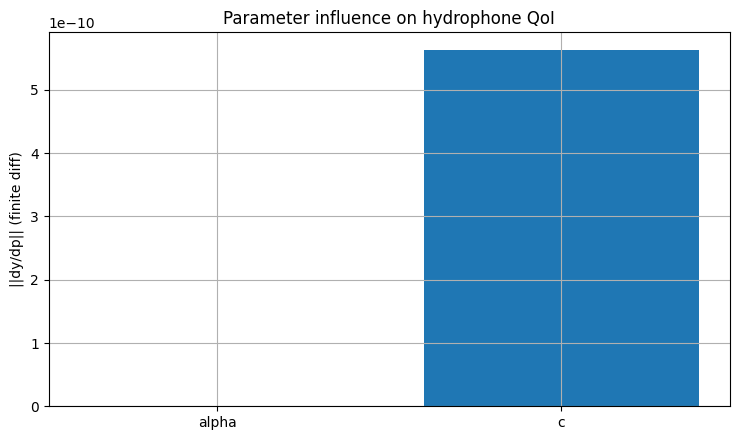

In [6]:
# Define QoI: hydrophone pressures y = C x (steady-state, constant u)
def compute_y(p, u0=1.0):
    x = solve_steady(p, u0=u0)
    C = build_C(p)
    return (C @ x).reshape(-1,1)

def finite_diff_sens(p, pname, dp, u0=1.0):
    # baseline
    y0 = compute_y(p, u0)
    # perturbed parameter
    pval = p[pname]
    p_pert = rebuild_params_like(p, **{pname: pval + dp})
    y1 = compute_y(p_pert, u0)
    return (y1 - y0) / dp

# Example run
Nx, Nz, Lx, Lz = 20, 10, 100, 50
p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
# Choose dp per PM2 guidance
eps = np.finfo(float).eps
dp_alpha = math.sqrt(2*eps) * max(1.0, abs(p['alpha']))
dp_c = math.sqrt(2*eps) * max(1.0, abs(p['c']))

S_alpha = finite_diff_sens(p, 'alpha', dp_alpha)
S_c     = finite_diff_sens(p, 'c', dp_c)

# Rank sensitivities by magnitude (sum across hydrophones)
mag = np.array([np.linalg.norm(S_alpha), np.linalg.norm(S_c)])
labels = ['alpha', 'c']
plt.bar(labels, mag)
plt.ylabel('||dy/dp|| (finite diff)')
plt.title('Parameter influence on hydrophone QoI')
plt.tight_layout(); plt.show()


## Task C — Conditioning of L (steady matrix)

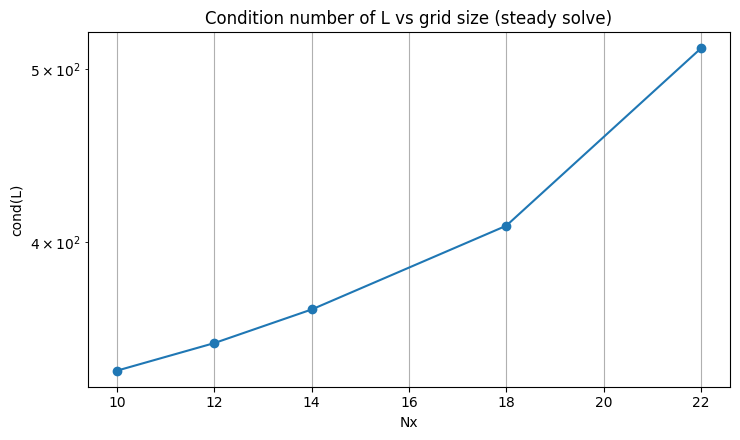

cond(L) @ alpha=1e-4: 366.64905597825464
cond(L) @ alpha=1e-2: 366.64905597825464


In [7]:
# cond(L) vs Nx (alpha-independent)
def measure_cond_L(Nx_list=(10,12,14,18,22), Nz=10, Lx=100, Lz=50):
    vals = []
    for Nx in Nx_list:
        p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False)
        L = extract_L(p)
        try:
            kappa = dense_cond(L)
        except Exception:
            kappa = np.nan
        vals.append((Nx, kappa))
    return np.array(vals, dtype=float)

vals = measure_cond_L()
plt.semilogy(vals[:,0], vals[:,1], 'o-')
plt.xlabel('Nx')
plt.ylabel('cond(L)')
plt.title('Condition number of L vs grid size (steady solve)')
plt.tight_layout(); plt.show()

# Sanity: confirm cond(L) does not change with alpha
Nx, Nz, Lx, Lz = 14, 10, 100, 50
p1, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False)
p2, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False)
p2['alpha'] = 1e-2
L1, L2 = extract_L(p1), extract_L(p2)
print('cond(L) @ alpha=1e-4:', dense_cond(L1))
print('cond(L) @ alpha=1e-2:', dense_cond(L2))

## Task D — Relative sensitivities and dp sweep (steady QoI)

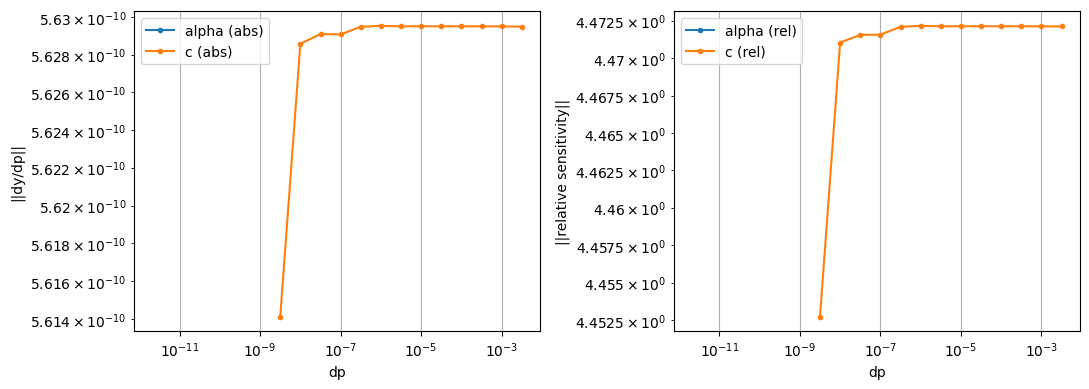

In [8]:
# Relative sensitivity: unitless measure (% change in y per % change in p)
def relative_sensitivity(p, pname, dp, u0=1.0):
    y0 = compute_y(p, u0)
    dY = finite_diff_sens(p, pname, dp, u0)
    pval = float(p[pname])
    eps = 1e-16
    rel = (dY.flatten() / (np.abs(y0.flatten()) + eps)) * (abs(pval) if pval != 0 else 1.0)
    return np.linalg.norm(rel)

Nx, Nz, Lx, Lz = 20, 10, 100, 50
p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
eps = np.finfo(float).eps
base_alpha = math.sqrt(2*eps) * max(1.0, abs(p['alpha']))
base_c     = math.sqrt(2*eps) * max(1.0, abs(p['c']))
mult = 10.0 ** np.linspace(-4, 2, 13)
dp_alpha_sweep = base_alpha * mult
dp_c_sweep     = base_c * mult

abs_alpha = [np.linalg.norm(finite_diff_sens(p, 'alpha', dp)) for dp in dp_alpha_sweep]
abs_c     = [np.linalg.norm(finite_diff_sens(p, 'c', dp))     for dp in dp_c_sweep]
rel_alpha = [relative_sensitivity(p, 'alpha', dp) for dp in dp_alpha_sweep]
rel_c     = [relative_sensitivity(p, 'c', dp)     for dp in dp_c_sweep]

fig, ax = plt.subplots(1,2, figsize=(11,4))
ax[0].loglog(dp_alpha_sweep, abs_alpha, '.-', label='alpha (abs)')
ax[0].loglog(dp_c_sweep,     abs_c,     '.-', label='c (abs)')
ax[0].set_xlabel('dp')
ax[0].set_ylabel('||dy/dp||')
ax[0].legend()

ax[1].loglog(dp_alpha_sweep, rel_alpha, '.-', label='alpha (rel)')
ax[1].loglog(dp_c_sweep,     rel_c,     '.-', label='c (rel)')
ax[1].set_xlabel('dp')
ax[1].set_ylabel('||relative sensitivity||')
ax[1].legend()
plt.tight_layout(); plt.show()


## Transient QoI — α effect (peak hydrophone amplitude)

Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 106 leapfrog steps...
  Progress: 9.3%
  Progress: 18.7%
  Progress: 28.0%
  Progress: 37.4%
  Progress: 46.7%
  Progress: 56.1%
  Progress: 65.4%
  Progress: 74.8%
  Progress: 84.1%
  Progress: 93.5%
Leapfrog integration complete!
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 106 leapfrog steps...
  Progress: 9.3%
  Progress: 18.7%
  Progress: 28.0%
  Progress: 37.4%
  Progress: 46.7%
  Progress: 56.1%
  Progress: 65.4%
  Progress: 74.8%
  Progress: 84.1%
  Progress: 93.5%
Leapfrog integration complete!
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 106 leapfrog steps...
  Progress: 9.3%
  Progress: 18.7%
  Progress: 28.0%
  Progress: 37.4%
  Progress: 46.7%
  Progress: 56.1%
  Progress: 65.4%
  Progress: 74.8%
  Progress: 84.1%
  Progress: 93.5%
Leapfrog integration complete!
Running Leapfrog

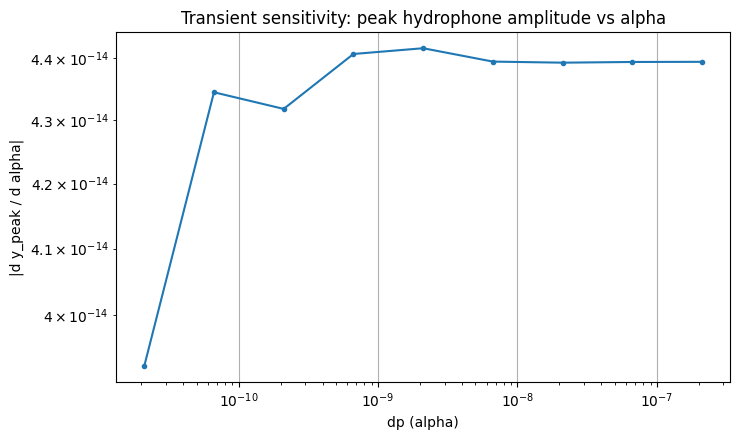

In [9]:
# Use a short leapfrog run; define QoI as max |y(t)| across hydrophones
def peak_hydrophone_amplitude(p, num_iter, dt):
    # Use baseline x_start from fresh params to align shapes
    q, x_start, _, _, _ = getParam_Sonar(p['Nx'], p['Nz'], p['Lx'], p['Lz'], UseSparseMatrices=sp.issparse(p['A']))
    # copy A/B from p (may be modified by rebuild_params_like)
    q['A'] = p['A']; q['B'] = p['B']; q['alpha'] = p['alpha']; q['c'] = p['c']
    X, t = LeapfrogSolver(eval_f_Sonar, x_start, q, eval_u_Sonar, num_iter, dt, visualize=False)
    peak = 0.0
    for i in range(len(t)):
        y = eval_g_Sonar(X[:, i], q)
        peak = max(peak, float(np.max(np.abs(y))))
    return peak

Nx, Nz, Lx, Lz = 20, 10, 100, 50
p, x0, t0, t1, dt_max = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
dt = dt_max * 0.5
num_iter = int(max(10, (t1 - t0) / dt))

eps = np.finfo(float).eps
base_alpha = math.sqrt(2*eps) * max(1.0, abs(p['alpha']))
dp_sweep = base_alpha * (10.0 ** np.linspace(-3, 1, 9))

y0_peak = peak_hydrophone_amplitude(p, num_iter, dt)
sens = []
for dp in dp_sweep:
    p_pert = rebuild_params_like(p, alpha=p['alpha'] + dp)
    y1_peak = peak_hydrophone_amplitude(p_pert, num_iter, dt)
    sens.append(abs((y1_peak - y0_peak) / dp))

plt.loglog(dp_sweep, sens, '.-')
plt.xlabel('dp (alpha)')
plt.ylabel('|d y_peak / d alpha|')
plt.title('Transient sensitivity: peak hydrophone amplitude vs alpha')
plt.tight_layout(); plt.show()


## Conclusions
- Summarize conditioning trends vs alpha/grid.
- Report stable dp ranges and most influential parameters.
- Note pitfalls (e.g., low damping, boundary extremes).

## Task D — Source location sensitivity (steady QoI)

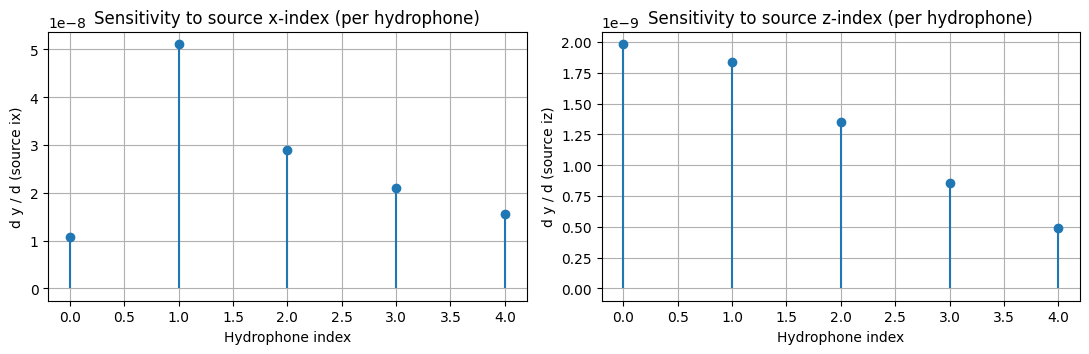

In [10]:
# Central/one-sided FD sensitivity to source indices (per hydrophone)
def sens_source_index(p, axis='x', h=1, u0=1.0):
    y0 = compute_y(p, u0).flatten()
    si, sj = p['sonar_ix'], p['sonar_iz']
    Nx, Nz = p['Nx'], p['Nz']

    if axis == 'x':
        if 0 < si < Nx-1:
            p_plus  = rebuild_params_like(p, sonar_ix=si+h)
            p_minus = rebuild_params_like(p, sonar_ix=si-h)
            y_plus  = compute_y(p_plus, u0).flatten()
            y_minus = compute_y(p_minus, u0).flatten()
            return (y_plus - y_minus) / (2*h)
        elif si == 0:
            p_plus = rebuild_params_like(p, sonar_ix=si+h)
            return (compute_y(p_plus, u0).flatten() - y0) / h
        else:
            p_minus = rebuild_params_like(p, sonar_ix=si-h)
            return (y0 - compute_y(p_minus, u0).flatten()) / h
    else: # axis=='z'
        if 0 < sj < Nz-1:
            p_plus  = rebuild_params_like(p, sonar_iz=sj+h)
            p_minus = rebuild_params_like(p, sonar_iz=sj-h)
            y_plus  = compute_y(p_plus, u0).flatten()
            y_minus = compute_y(p_minus, u0).flatten()
            return (y_plus - y_minus) / (2*h)
        elif sj == 0:
            p_plus = rebuild_params_like(p, sonar_iz=sj+h)
            return (compute_y(p_plus, u0).flatten() - y0) / h
        else:
            p_minus = rebuild_params_like(p, sonar_iz=sj-h)
            return (y0 - compute_y(p_minus, u0).flatten()) / h

# Example per-hydrophone sensitivities for source x/z indices
Nx, Nz, Lx, Lz = 20, 10, 100, 50
p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
S_ix = sens_source_index(p, axis='x')
S_iz = sens_source_index(p, axis='z')

fig, ax = plt.subplots(1,2, figsize=(11,3.8))
ax[0].stem(np.arange(len(S_ix)), S_ix, basefmt=' ')
ax[0].set_xlabel('Hydrophone index')
ax[0].set_ylabel('d y / d (source ix)')
ax[0].set_title('Sensitivity to source x-index (per hydrophone)')
ax[1].stem(np.arange(len(S_iz)), S_iz, basefmt=' ')
ax[1].set_xlabel('Hydrophone index')
ax[1].set_ylabel('d y / d (source iz)')
ax[1].set_title('Sensitivity to source z-index (per hydrophone)')
plt.tight_layout(); plt.show()


## Task D — Sensitivity heatmap across hydrophones

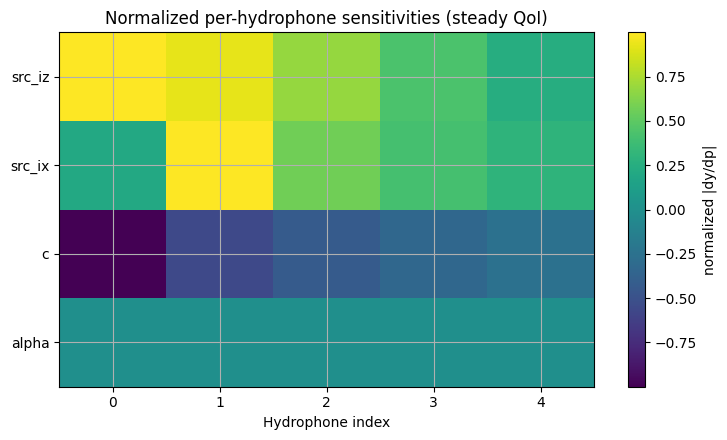

In [11]:
# Build a per-parameter, per-hydrophone sensitivity heatmap (normalized per row)
Nx, Nz, Lx, Lz = 20, 10, 100, 50
p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
eps = np.finfo(float).eps
dp_alpha = math.sqrt(2*eps) * max(1.0, abs(p['alpha']))
dp_c     = math.sqrt(2*eps) * max(1.0, abs(p['c']))

s_alpha = finite_diff_sens(p, 'alpha', dp_alpha).flatten()
s_c     = finite_diff_sens(p, 'c', dp_c).flatten()
s_ix    = sens_source_index(p, axis='x').flatten()
s_iz    = sens_source_index(p, axis='z').flatten()

S = np.vstack([s_alpha, s_c, s_ix, s_iz])
# Row-normalize for pattern comparison
S_norm = S / (np.max(np.abs(S), axis=1, keepdims=True) + 1e-16)
labels = ['alpha','c','src_ix','src_iz']

plt.imshow(S_norm, aspect='auto', origin='lower', cmap='viridis')
plt.yticks(range(len(labels)), labels)
plt.xlabel('Hydrophone index')
plt.title('Normalized per-hydrophone sensitivities (steady QoI)')
plt.colorbar(label='normalized |dy/dp|')
plt.tight_layout(); plt.show()


## Task D — Relative source-location sensitivities (unitless)

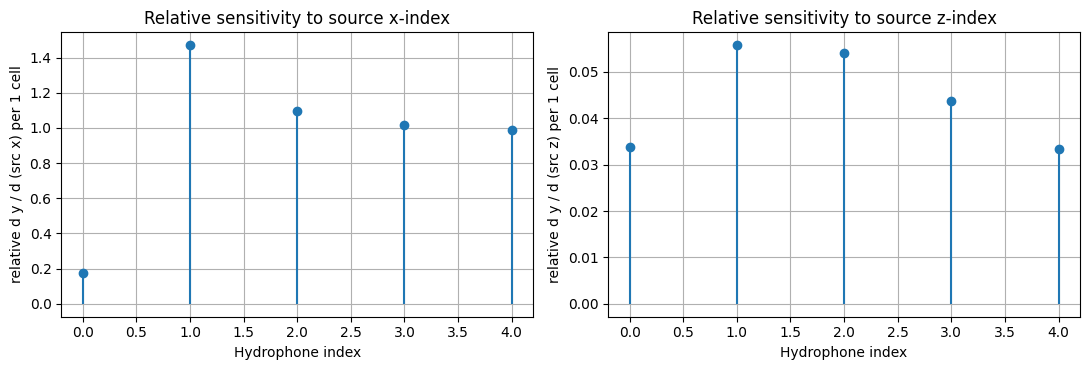

In [12]:
# Compute unitless relative sensitivities for source indices: (1/y) dy/d(index) * (cell size)
Nx, Nz, Lx, Lz = 20, 10, 100, 50
p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
y0 = compute_y(p).flatten()
S_ix = sens_source_index(p, axis='x').flatten()
S_iz = sens_source_index(p, axis='z').flatten()
epsy = 1e-16
Srel_ix = (S_ix * p['dx']) / (np.abs(y0) + epsy)
Srel_iz = (S_iz * p['dz']) / (np.abs(y0) + epsy)

fig, ax = plt.subplots(1,2, figsize=(11,3.8))
ax[0].stem(np.arange(len(Srel_ix)), Srel_ix, basefmt=' ')
ax[0].set_xlabel('Hydrophone index')
ax[0].set_ylabel('relative d y / d (src x) per 1 cell')
ax[0].set_title('Relative sensitivity to source x-index')
ax[1].stem(np.arange(len(Srel_iz)), Srel_iz, basefmt=' ')
ax[1].set_xlabel('Hydrophone index')
ax[1].set_ylabel('relative d y / d (src z) per 1 cell')
ax[1].set_title('Relative sensitivity to source z-index')
plt.tight_layout(); plt.show()


## Task D — Signed sensitivity heatmap (steady QoI)

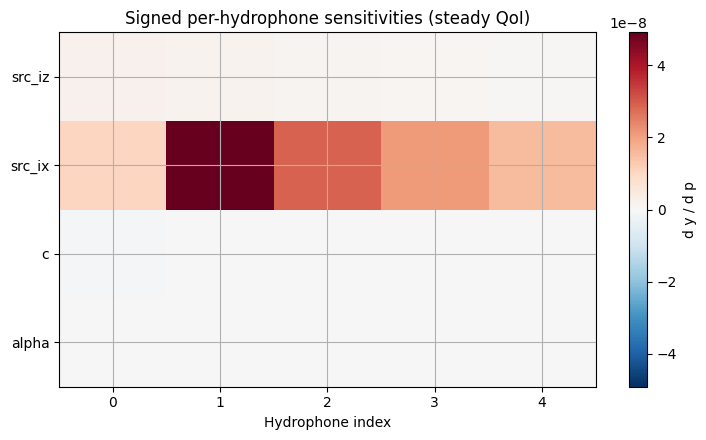

In [13]:
# Signed (not normalized) sensitivities to show direction of influence
Nx, Nz, Lx, Lz = 20, 10, 100, 50
p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
eps = np.finfo(float).eps
dp_alpha = math.sqrt(2*eps) * max(1.0, abs(p['alpha']))
dp_c     = math.sqrt(2*eps) * max(1.0, abs(p['c']))

s_alpha = finite_diff_sens(p, 'alpha', dp_alpha).flatten()
s_c     = finite_diff_sens(p, 'c', dp_c).flatten()
s_ix    = sens_source_index(p, axis='x').flatten()
s_iz    = sens_source_index(p, axis='z').flatten()

S_signed = np.vstack([s_alpha, s_c, s_ix, s_iz])
labels = ['alpha','c','src_ix','src_iz']
# Symmetric color scale around zero for visibility
vmax = np.quantile(np.abs(S_signed), 0.995)
vmin = -vmax
plt.imshow(S_signed, aspect='auto', origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.yticks(range(len(labels)), labels)
plt.xlabel('Hydrophone index')
plt.title('Signed per-hydrophone sensitivities (steady QoI)')
plt.colorbar(label='d y / d p')
plt.tight_layout(); plt.show()


### Sensitivity heatmap (normalized)
- Rows normalized to compare patterns across parameters.
- c shows broad influence; α ~ 0 for steady QoI; source ix/iz show spatial gradients along the array.

## Task F - Sparsity & Reordering

### a) How sparse are the matrices? Visualized the matrix with the sparsity and estimate the computational complexity for factoring it "as is" as well estimating an upper bound for the possible fill-ins that may occur?

[A] n=20,000, nnz(M)=69,600, density=1.740e-04
    envelopes on original pattern:
    lower envelope  ρ_L = 100,990,099
    upper envelope  ρ_U = 100,000,000
    total profile   ρ   = 201,010,099
    half-bandwidth  β   = 10,100


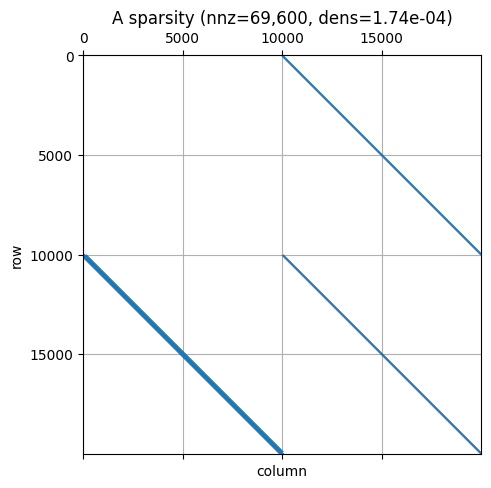

[A] Banded-LU upper bounds (as-is ordering):
    ~ flops ≤ 1.360e+12
    ~ nnz(LU) ≤ 4.040e+08  (vs nnz(A) = 69,600)


In [14]:
def to_csr(M):
    """Return CSR sparse matrix without copying big dense inputs unless needed."""
    if sp.issparse(M):
        return M.tocsr()
    M = np.asarray(M)
    return sp.csr_matrix(M)

def half_bandwidth(M):
    """
    Compute half-bandwidth β = max_{(i,j) in nz} |i - j| using the symmetric pattern.
    """
    M = to_csr(M)
    # symmetric pattern
    S = (M != 0).astype(np.int8)
    S = (S + S.T).astype(np.int8)
    S = S.tocoo()
    if S.nnz == 0:
        return 0
    return int(np.max(np.abs(S.row - S.col)))

def sparsity_stats(M, name="A", show=True, markersize=0.01, symmetrize=False):
    """
    Print sparsity, envelopes, and skyline profile for M.

    Envelopes are computed on the *symmetrized* pattern S = nz(M) ∪ nz(Mᵀ)
    (set symmetrize=False to use M's original pattern).

    For each row i with nonzeros in S:
      j_min(i) = leftmost column index
      j_max(i) = rightmost column index

    Lower envelope  ρ_L = Σ_i max(0, i - j_min(i))
    Upper envelope  ρ_U = Σ_i max(0, j_max(i) - i)
    Total profile   ρ   = ρ_L + ρ_U + n         (includes diagonal)
    Half-bandwidth  β   = max_i max(i - j_min(i), j_max(i) - i)

    Returns a dict with these quantities.
    """
    M = to_csr(M)
    n = M.shape[0]

    # Choose pattern to analyze
    P = (M != 0).astype(np.int8)
    if symmetrize:
        P = (P + P.T).astype(np.int8)
    P = P.tocsr()

    # Basic counts on the original matrix M (not the symmetrized pattern)
    nnz = M.nnz
    density = nnz / (n * n)

    # Row-wise envelopes
    indptr, indices = P.indptr, P.indices
    rho_L = 0  # lower (to the left of diag)
    rho_U = 0  # upper (to the right of diag)
    beta  = 0  # half-bandwidth

    for i in range(n):
        start, end = indptr[i], indptr[i+1]
        if end == start:
            continue  # empty row in pattern
        jmin = indices[start]
        jmax = indices[end - 1]
        # ensure monotone (CSR indices are sorted by row)
        dl = max(0, i - jmin)   # distance to leftmost nz
        du = max(0, jmax - i)   # distance to rightmost nz
        rho_L += dl
        rho_U += du
        if dl > beta: beta = dl
        if du > beta: beta = du

    rho_total = rho_L + rho_U + n  # include diagonal

    # Print report
    print(f"[{name}] n={n:,}, nnz(M)={nnz:,}, density={density:.3e}")
    print(f"    envelopes on {'symmetrized' if symmetrize else 'original'} pattern:")
    print(f"    lower envelope  ρ_L = {rho_L:,}")
    print(f"    upper envelope  ρ_U = {rho_U:,}")
    print(f"    total profile   ρ   = {rho_total:,}")
    print(f"    half-bandwidth  β   = {beta:,}")

    # Visualize sparsity of the original M
    if show:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.spy(M, markersize=markersize)
        ax.set_title(f"{name} sparsity (nnz={nnz:,}, dens={density:.2e})")
        ax.set_xlabel("column")
        ax.set_ylabel("row")
        plt.tight_layout()
        plt.show()

    return {
        "n": n,
        "nnz": nnz,
        "density": density,
        "lower_envelope": int(rho_L),
        "upper_envelope": int(rho_U),
        "profile_total": int(rho_total),
        "beta": int(beta),
        "symmetrized": bool(symmetrize),
    }

def lu_band_cost_upper_bounds(n, beta):
    """
    Common back-of-envelope bounds for banded LU *without pivoting*:
      - Flop count ~ (2/3) * n * beta^2
      - Storage (LU factors) ~ n * (2*beta + 1) nonzeros
    These are crude UPPER bounds; actual costs can be lower if solver does pivoting and reordering.
    """
    flops = (2/3) * n * (beta**2)
    nnz_LU_upper = n * (2*beta + 1)
    return int(flops), int(nnz_LU_upper)


# --- Analyze A ---------------------------------------
Nx, Nz, Lx, Lz = 100, 100, 100, 100
p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
A_csr = to_csr(p["A"])
stats_A = sparsity_stats(A_csr, name="A", show=True)

flops_A, nnzLU_A = lu_band_cost_upper_bounds(stats_A["n"], stats_A["beta"])
print(f"[A] Banded-LU upper bounds (as-is ordering):")
print(f"    ~ flops ≤ {flops_A:.3e}")
print(f"    ~ nnz(LU) ≤ {nnzLU_A:.3e}  (vs nnz(A) = {stats_A['nnz']:,})")

[L] n=10,000, nnz(M)=49,600, density=4.960e-04
    envelopes on original pattern:
    lower envelope  ρ_L = 990,099
    upper envelope  ρ_U = 990,099
    total profile   ρ   = 1,990,198
    half-bandwidth  β   = 100


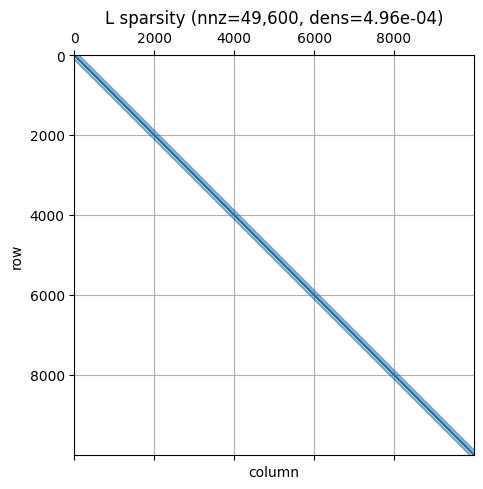

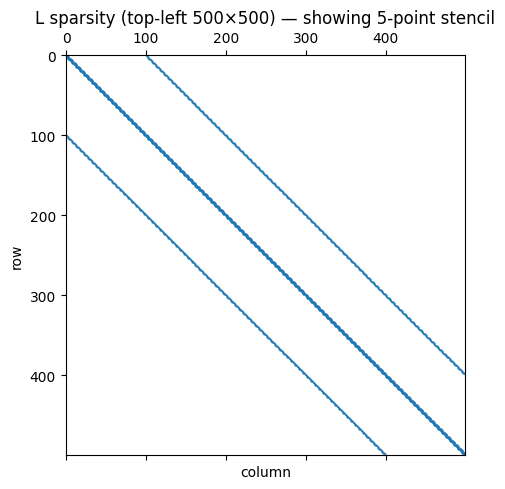

In [15]:
def extract_L_from_A(p):
    """Return L from block A = [[0, I],[c^2 L, -αI]]. If p['L'] exists, use it."""
    if 'L' in p:
        return to_csr(p['L'])

    A = to_csr(p['A'])
    n2 = A.shape[0]
    assert n2 % 2 == 0, "A must be 2N x 2N"
    N = n2 // 2

    # bottom-left block is c^2 * L  (same sparsity as L)
    L_tilde = A[N:, :N]              # CSR slice → CSR
    return L_tilde

# --- Analyze L ---------------------------------------
L_csr = extract_L_from_A(p)
stats_L = sparsity_stats(L_csr, name="L", show=True)

r = min(L_csr.shape[0], Nz * 5)
c = min(L_csr.shape[1], Nz * 5)
L_sub = L_csr[:r, :c]

fig, ax = plt.subplots(figsize=(5, 5))
ax.spy(L_sub, markersize=.5)
ax.set_xlabel("column")
ax.set_ylabel("row")
ax.set_title(f"L sparsity (top-left {r}×{c}) — showing 5-point stencil")
ax.set_xlim(-0.5, c-0.5)
ax.set_ylim(r-0.5, -0.5)  # keep origin at top-left visually
ax.grid(False)
plt.tight_layout()
plt.show()

In [16]:
from scipy.sparse.linalg import splu
# grid sizes to test
grids = [(10,10), (50,50), (100,100), (500,500)]
Lx = Lz = 100.0  # physical sizes (use whatever you’ve been using)

for Nx, Nz in grids:
    try:
        # build params and A (sparse)
        p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
        A = p["A"]
        if not sp.issparse(A):
            A = sp.csr_matrix(A)

        # time LU factorization (SuperLU)
        t0 = time.perf_counter()
        lu = splu(A.tocsc(), permc_spec="COLAMD", diag_pivot_thresh=1.0)
        t1 = time.perf_counter()

        print(f"LU(A) Nx={Nx:4d}, Nz={Nz:4d} | n={A.shape[0]:,} | time = {t1 - t0:.3f} s")
    except MemoryError:
        print(f"LU(A) Nx={Nx:4d}, Nz={Nz:4d} | n≈{(2*Nx*Nz):,} | SKIPPED (MemoryError)")
    except Exception as e:
        print(f"LU(A) Nx={Nx:4d}, Nz={Nz:4d} | ERROR: {type(e).__name__}: {e}")

LU(A) Nx=  10, Nz=  10 | n=200 | time = 0.000 s
LU(A) Nx=  50, Nz=  50 | n=5,000 | time = 0.004 s
LU(A) Nx= 100, Nz= 100 | n=20,000 | time = 0.022 s
LU(A) Nx= 500, Nz= 500 | n=500,000 | time = 1.464 s


Runtime grows roughly with the grid size because, in our natural ordering, the half-bandwidth is set by Nz (β≈Nz), so a banded LU has work ~ O(n·β²).
In practice, splu applies a fill-reducing ordering (e.g., COLAMD), which slashes effective bandwidth/fill so the observed scaling is closer to ~O(N^15) (e.g., quadrupling nodes → ~8× time).
So: Nz controls the band, and splu’s reordering is why the timings remain fast until you reach multi-million unknowns.

### b) Estimate speed up if matrix were reordered.

Comparing splu natrual which does no reordering to splu COLMAD which handles reordering as well as reverse_cuthill_mckee.

In [ ]:
from scipy.sparse.csgraph import reverse_cuthill_mckee

def to_csc(A): return A.tocsc() if sp.isspmatrix(A) else sp.csc_matrix(A)

def factor_time(A_csc, permc):
    t0 = time.perf_counter()
    lu = splu(A_csc, permc_spec=permc, diag_pivot_thresh=1.0)
    dt = time.perf_counter() - t0
    fill = (lu.L.nnz + lu.U.nnz) / A_csc.nnz  # How many more nonzeros in LU vs A
    return dt, fill

def run_reordering_speedup(Nx, Nz, Lx=100.0, Lz=100.0):
    p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
    A = p["A"];  A = A if sp.issparse(A) else sp.csr_matrix(A)
    A_csc = to_csc(A)

    # 1) Baseline: NATURAL (no column reordering)
    t_nat, fill_nat = factor_time(A_csc, "NATURAL")

    # 2) SuperLU’s fill-reducing ordering: COLAMD
    t_colamd, fill_colamd = factor_time(A_csc, "COLAMD")

    # 3) Variable reordering: RCM on the (symmetrized) pattern, then NATURAL
    perm = reverse_cuthill_mckee((A != 0).astype(np.int8))
    A_rcm = A[perm][:, perm]
    t_rcm_nat, fill_rcm_nat = factor_time(to_csc(A_rcm), "NATURAL")

    print(f"Nx=Nz={Nx:4d} | n={A.shape[0]:,}")
    print(f"  NATURAL    : time={t_nat:8.3f}s  fill={fill_nat:6.2f}x")
    print(f"  COLAMD     : time={t_colamd:8.3f}s  fill={fill_colamd:6.2f}x  (speedup vs NATURAL ≈ {t_nat/max(t_colamd,1e-12):.1f}×)")
    print(f"  RCM+NATURAL: time={t_rcm_nat:8.3f}s  fill={fill_rcm_nat:6.2f}x  (speedup vs NATURAL ≈ {t_nat/max(t_rcm_nat,1e-12):.1f}×)")

# Example sweep (keep sizes reasonable to avoid OOM):
for n in [50, 100, 150, 200]:
    run_reordering_speedup(n, n)

Nx=Nz=  50 | n=5,000
  NATURAL    : time=   0.152s  fill=195.45
  COLAMD     : time=   0.004s  fill=  6.89  (speedup vs NATURAL ≈ 35.0×)
  RCM+NATURAL: time=   0.005s  fill= 14.07  (speedup vs NATURAL ≈ 28.0×)
Nx=Nz= 100 | n=20,000
  NATURAL    : time=   3.477s  fill=747.49
  COLAMD     : time=   0.022s  fill=  9.68  (speedup vs NATURAL ≈ 160.3×)
  RCM+NATURAL: time=   0.052s  fill= 27.16  (speedup vs NATURAL ≈ 67.0×)
Nx=Nz= 150 | n=45,000
  NATURAL    : time=  26.200s  fill=1656.67
  COLAMD     : time=   0.057s  fill= 11.83  (speedup vs NATURAL ≈ 462.3×)
  RCM+NATURAL: time=   0.219s  fill= 40.26  (speedup vs NATURAL ≈ 119.7×)
Nx=Nz= 200 | n=80,000
  NATURAL    : time= 104.428s  fill=2923.00
  COLAMD     : time=   0.121s  fill= 13.17  (speedup vs NATURAL ≈ 862.2×)
  RCM+NATURAL: time=   0.620s  fill= 53.35  (speedup vs NATURAL ≈ 168.4×)


In the natural ordering, the matrix’s “band” is set by Nz, so elimination creates tons of new nonzeros (“fill”), making LU slow as the grid gets bigger. COLAMD (the default in splu) reorders the columns to reduce fill, so the factors are much sparser and the LU runs tens to hundreds of times faster. RCM (Reverse Cuthill–McKee) is a symmetric graph reordering that shrinks bandwidth; it helps, but not as much as COLAMD for our unsymmetric block system, so its speedups are smaller.